### ISIC-Net (ResNet50) — HAM10000 + BCN20000
- **Goal**: Binary dermoscopic image classification with a fine-tuned ResNet50.
- **Datasets**: HAM10000 and BCN20000 combined, with metadata features (sex, age, anatomical site).
- **Backbone**: ImageNet-pretrained ResNet50; custom head + metadata MLP.
- **Result (test)**: **Accuracy 88.1%**. See the classification report cell for precision/recall/F1 and the confusion matrix cell for error patterns.
- **How to use**: Run cells sequentially to prepare data, train, evaluate, and save weights.

### Setup and dependencies
Imports core libraries (PyTorch, TorchVision, NumPy, Pandas, etc.), configures deterministic behavior for reproducibility, and silences non-critical warnings.

### Data paths
Configure dataset base directories for HAM10000 and BCN20000. Update paths if running outside Kaggle.

In [1]:
import os
import random
from pathlib import Path
from typing import Any, List, Sequence, Tuple

import cv2
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from collections import defaultdict, Counter
from dataclasses import dataclass
import pandas as pd
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

### Data schema and label mappings
Defines `ISICImage` data class and mappings for sex, diagnosis (binary target), and anatomical site. These mappings are used both for dataset construction and metadata normalization.

In [2]:
base_dir = Path("/kaggle/input/")
ham_dir = base_dir / "ham10000" / "ISIC-images"
bcn_dir = base_dir / "bcn20000"

### Metadata loading and filtering
- Concatenates HAM10000 + BCN20000 metadata, de-duplicates by `isic_id`.
- Filters to usable records and constructs `ISICImage` objects.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Dataset and transforms
- Image pipeline: resize-with-pad to 600x450, normalization with ImageNet stats, basic augmentation on train.
- Metadata features: sex, age, anatomical site → normalized per-split.
- `__getitem__`: returns `(image_tensor, meta_tensor, label)`.

In [4]:
@dataclass(frozen=True)
class ISICImage:
    path: Path
    identifier: str
    age: str
    sex: str
    diagnosis: str
    anatom_site: str

SEX_MAPPING = {
    "male": 0,
    "female": 1
}

DIAGNOSIS_MAPPING = {
    "Malignant": 0,
    "Benign": 1
}

ANATOM_SITE_MAPPING = {
    "anterior torso": 0,
    "posterior torso": 1,
    "head/neck": 2,
    "upper extremity": 3,
    "lower extremity": 4,
    "palms/soles": 5,
    "oral/genital": 6
}

In [5]:
def concat_metadata(paths: List[Path]) -> pd.DataFrame:
    data = pd.DataFrame()
    for path in paths:
        metadata = pd.read_csv(path / "metadata.csv")
        metadata["base_path"] = path.as_posix()
        data = pd.concat([data, metadata])
    data = data.drop_duplicates(["isic_id"])
    return data

### Train/val/test split and loaders
- Stratified split on the binary target.
- DataLoaders with deterministic shuffling for train, smaller workers for val/test.

In [6]:
def load_metadata(metadata: pd.DataFrame) -> List[ISICImage]:
    metadata = metadata[pd.notnull(metadata["age_approx"])]
    metadata = metadata[pd.notnull(metadata["sex"])]
    metadata = metadata[pd.notnull(metadata["anatom_site_general"])]
    metadata = metadata[metadata["diagnosis_1"].isin(["Malignant", "Benign"])]
    images: List[ISICImage] = []
    for idx, row in metadata.iterrows():
        images.append(
            ISICImage(
                path=Path(row["base_path"]),
                identifier=row["isic_id"],
                age=row["age_approx"],
                sex=row["sex"],
                diagnosis=row["diagnosis_1"],
                anatom_site=row["anatom_site_general"]
            )
        )
    return images

### Backbone initialization
- Load ImageNet-pretrained ResNet50.
- Freeze all parameters initially and set BatchNorm layers to eval for stable features.

In [7]:
def print_diagnosis_counts_by_sex(images: List[ISICImage]) -> None:
    counts_by_sex: dict[int, Counter[int]] = defaultdict(Counter)
    for img in images:
        counts_by_sex[img.sex][img.diagnosis] += 1

    all_diagnoses = sorted({d for ctr in counts_by_sex.values() for d in ctr})
    all_sexes = sorted(counts_by_sex)

    diag_col = "Diagnosis"
    sex_cols = [f"Sex {s}" for s in all_sexes]

    w_diag = max(len(diag_col), *(len(str(d)) for d in all_diagnoses))
    w_sex = {
        s: max(len(f"Sex {s}"), *(len(str(counts_by_sex[s][d])) for d in all_diagnoses))
        for s in all_sexes
    }

    header = f"{diag_col:<{w_diag}} " + " ".join(
        f"| {name:>{w_sex[s]}}" for s, name in zip(all_sexes, sex_cols)
    )
    sep = "-" * len(header)
    print(header)
    print(sep)

    for d in all_diagnoses:
        row = f"{str(d):<{w_diag}} " + " ".join(
            f"| {counts_by_sex[s][d]:>{w_sex[s]}}" for s in all_sexes
        )
        print(row)

In [8]:
class ResizeWithPad:
    def __init__(self, target_size: Tuple[int, int], fill: int = 0) -> None:
        self.target_size = target_size  # (height, width)
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        target_h, target_w = self.target_size
        orig_w, orig_h = img.size

        # Scale by shorter side
        scale = min(target_w / orig_w, target_h / orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)

        # Compute padding
        pad_w = target_w - new_w
        pad_h = target_h - new_h
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        # Pad
        img = transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=self.fill)
        return img

### Model head with metadata
- Replace `resnet50.fc` with identity to extract features.
- `meta_net`: small MLP over 3 meta features (sex, age, site).
- `classifier`: concatenates image + meta features → 2-class logits.
- `ISICNet`: wrapper module combining components.

In [9]:
def compute_mean_std(values: List[Any]) -> Tuple[float, float]:
    arr = np.array(values, dtype=np.float32)
    return float(arr.mean()), float(arr.std())

def normalize_meta(values: Sequence[float], means: Sequence[float], stds: Sequence[float]) -> torch.Tensor:
    normed = [(v - m) / s for v, m, s in zip(values, means, stds)]
    return torch.tensor(normed, dtype=torch.float32)

### Evaluation helper
Batched evaluation returning loss, accuracy, predictions and labels. Used for val/test.

In [10]:
class ISICImageDiagnosisDataset(Dataset):
    def __init__(self, images: List[ISICImage], train: bool) -> None:
        self.images = images
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        ages = [img.age for img in images]
        self.mean_age, self.std_age = compute_mean_std(ages)
        
        sexes = [SEX_MAPPING[img.sex] for img in images]
        self.mean_sex, self.std_sex = compute_mean_std(sexes)

        sites = [ANATOM_SITE_MAPPING[img.anatom_site] for img in images]
        self.mean_site, self.std_site = compute_mean_std(sites)

        if not train:
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                ResizeWithPad((600, 450), fill=(0, 0, 0)),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std),
            ])
        else:
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                ResizeWithPad((600, 450), fill=(0, 0, 0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std)
            ])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        image = self.images[index]
        image_path = image.path / f"{image.identifier}.jpg"
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)

        sex = SEX_MAPPING[image.sex]
        diagnosis = DIAGNOSIS_MAPPING[image.diagnosis]
        site = ANATOM_SITE_MAPPING[image.anatom_site]
        age = float(image.age)
    
        meta = normalize_meta(
            values=[sex, age, site],
            means=[self.mean_sex, self.mean_age, self.mean_site],
            stds=[self.std_sex, self.std_age, self.std_site]
        )
        return img, meta, diagnosis

### Class imbalance handling
Compute per-class weights from training distribution and pass to `CrossEntropyLoss`.

In [11]:
metadata = concat_metadata(paths=[bcn_dir, ham_dir])
images = load_metadata(metadata=metadata)
print_diagnosis_counts_by_sex(images=images)

Diagnosis | Sex female | Sex male
---------------------------------
Benign    |       7521 |     7484
Malignant |       4615 |     6097


### Training strategy
- Stage 1: train only metadata MLP + classifier (frozen backbone) with OneCycleLR.
- Stage 2: unfreeze `layer4` and continue fine-tuning with reduced LRs.
- Early stopping on best validation loss.

In [12]:
from sklearn.model_selection import train_test_split

labels = [DIAGNOSIS_MAPPING[img.diagnosis] for img in images]

train_images, temp_images, _, temp_labels = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=SEED
)

val_images, test_images, _, _ = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

In [13]:
train = ISICImageDiagnosisDataset(train_images, train=True)
test = ISICImageDiagnosisDataset(test_images, train=False)
val = ISICImageDiagnosisDataset(val_images, train=False)

g = torch.Generator()
g.manual_seed(SEED)

trainloader = DataLoader(train, shuffle=True, batch_size=64, generator=g, num_workers=6)
testloader = DataLoader(test, shuffle=False, batch_size=32, num_workers=2)
valloader = DataLoader(val, shuffle=False, batch_size=32, num_workers=2)

In [14]:
from torchvision.models import ResNet50_Weights
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s] 


In [15]:
for name, param in resnet50.named_parameters():
    param.requires_grad = False

### Test evaluation
Reports final test loss and accuracy. See the next cells for confusion matrix and scikit-learn classification report.

In [16]:
for name, module in resnet50.named_modules():
    if isinstance(module, torch.nn.BatchNorm2d):
        module.eval()

In [ ]:
num_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Identity()

meta_net = torch.nn.Sequential(
    torch.nn.Linear(3, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU()
)

classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features + 8, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 2)
)

class ISICNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet50
        self.meta_net = meta_net
        self.classifier = classifier

    def forward(self, img: torch.Tensor, meta: torch.Tensor) -> torch.Tensor:
        img_features = self.resnet(img)
        meta_features = self.meta_net(meta)
        x = torch.cat([img_features, meta_features], dim=1)
        return self.classifier(x)

In [26]:
from torchvision.models.resnet import ResNet
from torch.nn import CrossEntropyLoss

def evaluate(
    model: ResNet,
    loader: DataLoader,
    criterion: CrossEntropyLoss
) -> Tuple[int, int, List[np.ndarray], List[np.ndarray]]:
    model.eval()
    correct = total = 0
    running_loss = 0.0

    all_preds, all_labels = [], []

    with torch.no_grad():
        for (imgs, meta, labels) in tqdm(loader, desc=f"Evaluation: "):
            imgs, meta, labels = imgs.to(device), meta.to(device), labels.to(device)

            logits = model(imgs, meta)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            running_loss += loss.item() * imgs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_loss = running_loss / len(loader.dataset)
    return eval_loss, correct / total, all_preds, all_labels

### Confusion matrix
Visualizes per-class errors on the test set.

In [19]:
label_counts = Counter(DIAGNOSIS_MAPPING[image.diagnosis] for image in train_images)
classes = len(label_counts)

num_labels = sum(label_counts.values())
label_weights = []
for idx, (_, count) in enumerate(label_counts.items()):
    weight = num_labels / (classes * count)
    label_weights.append(weight)

weights = torch.tensor(label_weights, dtype=torch.float32)
weights = weights.to(device)

### Classification report
Full precision/recall/F1 by class and overall metrics.

In [ ]:
def unfreeze_layers(model: ISICNet, layers: List[str]) -> None:
    for name, param in model.resnet.named_parameters():
        for layer in layers:
            if name.startswith(layer):
                param.requires_grad = True

    for name, module in model.resnet.named_modules():
        for layer in layers:
            if name.startswith(layer) and isinstance(module, torch.nn.BatchNorm2d):
                module.train()
                for param in module.parameters():
                    param.requires_grad = True

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import AdamW

model = ISICNet()

EPOCHS = 100
STAGE_1_EPOCHS = 10

no_improve = 0
patience, best_loss = 10, float('inf')

param_groups_1 = [
    {"params": model.classifier.parameters(), "lr": 1e-2, "weight_decay": 1e-3},
    {"params": model.meta_net.parameters(), "lr": 1e-2, "weight_decay": 1e-3},
]

optimizer = AdamW(param_groups_1)
criterion = CrossEntropyLoss(weight=weights)
scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-2, 1e-2],
    epochs=STAGE_1_EPOCHS,                
    steps_per_epoch=len(trainloader),
    pct_start=0.25,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)

model.to(device)

torch.backends.cudnn.benchmark = True

for epoch in range(0, STAGE_1_EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, meta, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, meta, labels = imgs.to(device), meta.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs, meta)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        scheduler.step()

    val_loss, val_acc, _, _ = evaluate(model, valloader, criterion)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            break

    train_loss = running_loss / len(trainloader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Accuracy: {val_acc:.3f}..")

param_groups_2 = [
    {"params": model.classifier.parameters(), "lr": 1e-3, "weight_decay": 1e-3},
    {"params": model.meta_net.parameters(), "lr": 1e-3, "weight_decay": 1e-3},
    {"params": model.resnet.layer4.parameters(), "lr": 5e-4, "weight_decay": 1e-3},
]

optimizer = AdamW(param_groups_2)
scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-3, 1e-3, 5e-4],
    epochs=EPOCHS - STAGE_1_EPOCHS,                
    steps_per_epoch=len(trainloader),
    pct_start=0.25,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)
unfreeze_layers(model=model, layers=["layer4"])

for epoch in range(STAGE_1_EPOCHS, EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, meta, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, meta, labels = imgs.to(device), meta.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs, meta)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        scheduler.step()

    val_loss, val_acc, _, _ = evaluate(model, valloader, criterion)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            break

    train_loss = running_loss / len(trainloader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Accuracy: {val_acc:.3f}..")

Evaluation: 100%|██████████| 121/121 [01:27<00:00,  1.39it/s]


Epoch 1/100.. Train loss: 0.544.. Val loss: 0.509.. Accuracy: 0.756..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 2/100.. Train loss: 0.531.. Val loss: 0.485.. Accuracy: 0.764..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 3/100.. Train loss: 0.543.. Val loss: 0.522.. Accuracy: 0.748..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 4/100.. Train loss: 0.548.. Val loss: 0.510.. Accuracy: 0.751..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 5/100.. Train loss: 0.527.. Val loss: 0.513.. Accuracy: 0.741..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 6/100.. Train loss: 0.509.. Val loss: 0.459.. Accuracy: 0.771..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 7/100.. Train loss: 0.496.. Val loss: 0.452.. Accuracy: 0.763..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 8/100.. Train loss: 0.487.. Val loss: 0.453.. Accuracy: 0.780..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 9/100.. Train loss: 0.471.. Val loss: 0.450.. Accuracy: 0.779..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 10/100.. Train loss: 0.471.. Val loss: 0.450.. Accuracy: 0.780..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 11/100.. Train loss: 0.467.. Val loss: 0.438.. Accuracy: 0.795..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 12/100.. Train loss: 0.440.. Val loss: 0.405.. Accuracy: 0.805..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 13/100.. Train loss: 0.419.. Val loss: 0.392.. Accuracy: 0.815..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 14/100.. Train loss: 0.395.. Val loss: 0.388.. Accuracy: 0.833..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.67it/s]


Epoch 15/100.. Train loss: 0.368.. Val loss: 0.356.. Accuracy: 0.835..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 16/100.. Train loss: 0.345.. Val loss: 0.401.. Accuracy: 0.829..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 17/100.. Train loss: 0.315.. Val loss: 0.372.. Accuracy: 0.831..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.67it/s]


Epoch 18/100.. Train loss: 0.293.. Val loss: 0.337.. Accuracy: 0.858..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 19/100.. Train loss: 0.276.. Val loss: 0.351.. Accuracy: 0.853..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 20/100.. Train loss: 0.253.. Val loss: 0.366.. Accuracy: 0.852..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 21/100.. Train loss: 0.242.. Val loss: 0.343.. Accuracy: 0.851..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 22/100.. Train loss: 0.223.. Val loss: 0.387.. Accuracy: 0.834..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 23/100.. Train loss: 0.220.. Val loss: 0.336.. Accuracy: 0.869..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 24/100.. Train loss: 0.203.. Val loss: 0.344.. Accuracy: 0.869..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.67it/s]


Epoch 25/100.. Train loss: 0.192.. Val loss: 0.329.. Accuracy: 0.876..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 26/100.. Train loss: 0.187.. Val loss: 0.358.. Accuracy: 0.868..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 27/100.. Train loss: 0.182.. Val loss: 0.355.. Accuracy: 0.861..


Evaluation: 100%|██████████| 121/121 [01:11<00:00,  1.68it/s]


Epoch 28/100.. Train loss: 0.170.. Val loss: 0.411.. Accuracy: 0.859..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 29/100.. Train loss: 0.160.. Val loss: 0.625.. Accuracy: 0.843..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 30/100.. Train loss: 0.149.. Val loss: 0.439.. Accuracy: 0.869..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 31/100.. Train loss: 0.143.. Val loss: 0.383.. Accuracy: 0.846..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 32/100.. Train loss: 0.129.. Val loss: 0.445.. Accuracy: 0.875..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 33/100.. Train loss: 0.119.. Val loss: 0.385.. Accuracy: 0.883..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


Epoch 34/100.. Train loss: 0.114.. Val loss: 0.360.. Accuracy: 0.874..


Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]


In [27]:
test_loss, test_acc, test_preds, test_labels = evaluate(model, testloader, criterion)
print(f"Test loss: {test_loss:.3f}.. "
      f"Accuracy: {test_acc:.3f}..")

Evaluation: 100%|██████████| 121/121 [01:12<00:00,  1.68it/s]

Test loss: 0.350.. Accuracy: 0.881..


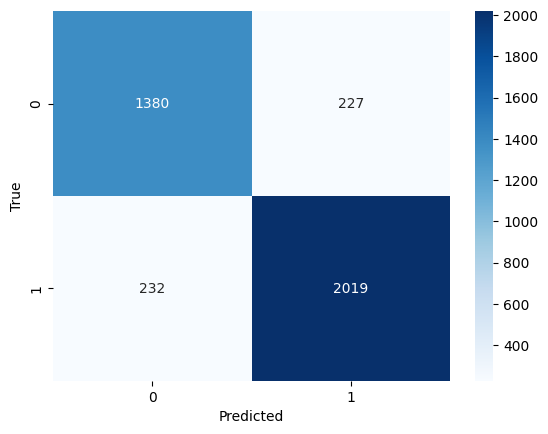

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, test_preds)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1607
           1       0.90      0.90      0.90      2251

    accuracy                           0.88      3858
   macro avg       0.88      0.88      0.88      3858
weighted avg       0.88      0.88      0.88      3858



In [23]:
torch.save(model.state_dict(), "ham-net.pth")